In [ ]:
# note error when running python due to some MKL error I think
# probably missing library

# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.7835300458752712
 0.49688685835208757
 0.06567164984021279
 0.6970717684601841
 0.7985792653443369
 0.027273251727268022
 0.8689340175531508
 0.589652838842295
 0.3864869950422103
 0.3993642070328802
 0.5016160763342636
 0.5433596674070551
 0.6045318128136148
 ⋮
 0.3606840396567341
 0.8244134056857662
 0.2942622490416711
 0.5865080434684737
 0.9383354733535112
 0.43133853649863285
 0.45085230066314264
 0.9830877980324662
 0.5689626158591015
 0.31426043933020154
 0.5510548114557232
 0.4630450820950134

In [2]:
sum(a)

5.000752797231948e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.005488 seconds (1 allocation: 16 bytes)


5.000752797231948e6

In [4]:
@time sum(a)

  0.004904 seconds (1 allocation: 16 bytes)


5.000752797231948e6

In [5]:
@time sum(a)

  0.004595 seconds (1 allocation: 16 bytes)


5.000752797231948e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/work/projects/julia/julia-academy/Introduction-to-Julia/Project.toml`
  No Changes to `~/work/projects/julia/julia-academy/Introduction-to-Julia/Manifest.toml`


In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):
open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

5.00075279723177e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

-1.778826117515564e-7

In [12]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [13]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.


We can now benchmark the C code directly from Julia:

In [14]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 501 samples with 1 evaluation.
 Range (min … max):  8.707 ms …  15.057 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.728 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.978 ms ± 978.483 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▃▂▂▁▆▂▄▂ █▃█ ▁▂▁                                           
  ▄▆████████████████▆▇█▅▆▇▄▂▆▄▅▅▅▄▅▅▂▃▃▄▃▃▄▃▂▁▄▄▃▁▂▂▃▁▂▁▂▂▁▁▂ ▄
  8.71 ms         Histogram: frequency by time        13.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [15]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 8.707202 msec


In [16]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 8.7072

In [17]:
using Plots
gr()

Plots.GRBackend()

In [18]:
typeof(c_bench.times)

Vector{Float64} (alias for Array{Float64, 1})

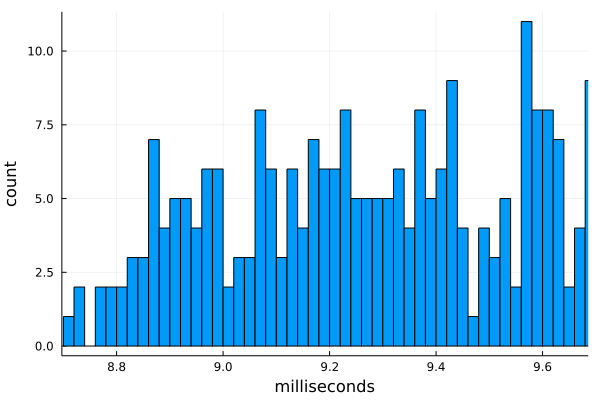

In [19]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [20]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [21]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 1320 samples with 1 evaluation.
 Range (min … max):  3.381 ms …  10.070 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.746 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.776 ms ± 217.561 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                       ▂█▇▅▃▄▅▅▂                               
  ▂▁▁▂▁▂▂▂▁▁▂▂▂▁▃▁▂▃▅▅▅███████████▇▆▆▆▅▄▅▅▅▄▅▃▃▃▃▃▃▃▂▃▂▁▂▁▂▂▂ ▄
  3.38 ms         Histogram: frequency by time        4.16 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [22]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

3.380712

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [40]:
# using Pkg; Pkg.add("PyCall")
using PyCall

In [41]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [ ]:
pysum(a)

In [ ]:
pysum(a) ≈ sum(a)

In [ ]:
py_list_bench = @benchmark $pysum($a)

In [28]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 9.38288
  "Python built-in" => 875.812
  "C -ffast-math"   => 1.78121

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [37]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
  No Changes to `~/work/projects/julia/julia-academy/Introduction-to-Julia/Project.toml`
  No Changes to `~/work/projects/julia/julia-academy/Introduction-to-Julia/Manifest.toml`


In [38]:
Conda.add("numpy")

┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /Users/spx8sk/.julia/packages/Conda/sNGum/src/Conda.jl:128


Solving environment: ...working... done

# All requested packages already installed.



In [39]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

LoadError: UndefVarError: pyimport not defined

In [32]:
numpy_sum(a)

5.000406093458153e6

In [33]:
numpy_sum(a) ≈ sum(a)

true

In [34]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 9.38288
  "Python numpy"    => 1.91263
  "Python built-in" => 875.812
  "C -ffast-math"   => 1.78121

# 5. Python, hand-written 

In [35]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7ff7d13c8b80>

In [36]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.012 s …  1.027 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.018 s             ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.019 s ± 6.023 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █       █              █        █                      █  
  █▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  110 s         Histogram: frequency by time         130 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [37]:
sum_py(a)

5.000406093458116e6

In [38]:
sum_py(a) ≈ sum(a)

true

In [39]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 9.38288
  "Python numpy"        => 1.91263
  "Python hand-written" => 1011.92
  "Python built-in"     => 875.812
  "C -ffast-math"       => 1.78121

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [23]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [24]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1091 samples with 1 evaluation.
 Range (min … max):  3.624 ms …   8.895 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.473 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.563 ms ± 416.041 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

              ▁▅▇▅█▇▇█▄▆▄▁▃▂▁                                  
  ▂▁▂▂▂▂▂▃▃▄▅▇███████████████▇▆▅▇▅▄▆▃▄▄▄▃▃▃▂▂▃▃▃▃▃▂▁▂▂▂▂▁▁▁▂▃ ▄
  3.62 ms         Histogram: frequency by time        6.12 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [25]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"              => 8.7072
  "Julia built-in" => 3.62423
  "C -ffast-math"  => 3.38071

# 7. Julia (hand-written) 

In [26]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [27]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 470 samples with 1 evaluation.
 Range (min … max):   9.221 ms …  14.107 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     10.566 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.615 ms ± 729.743 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

         ▁▂ ▂ ▂ ▃▁▁▂▄▆█▅▄▃▇▆▇▆▃▃  ▁                             
  ▅▃▆▅▆▄▇██████▇████████████████▆▇█▆▆▆█▅▆▄▄▅▄▄▃▃▁▃▅▃▃▃▁▁▃▃▁▃▃▃ ▅
  9.22 ms         Histogram: frequency by time         12.8 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [28]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"                  => 8.7072
  "Julia hand-written" => 9.22149
  "Julia built-in"     => 3.62423
  "C -ffast-math"      => 3.38071

# 8. Julia (hand-written w. simd) 

In [29]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [30]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 1105 samples with 1 evaluation.
 Range (min … max):  3.783 ms …   6.158 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.482 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.504 ms ± 212.446 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                       ▃ ▁▄▅▁▃▃▆▃█▄▃▂▅▃▁▂                      
  ▂▁▂▁▂▂▂▁▂▂▃▂▂▂▁▃▂▂▄▄▅███████████████████▇▇▆▅▆▄▅▄▄▄▅▄▃▃▃▃▂▂▃ ▄
  3.78 ms         Histogram: frequency by time        5.08 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [31]:
mysum_simd(a)

5.000752797231998e6

In [32]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "Julia hand-written simd" => 3.78339
  "C"                       => 8.7072
  "Julia hand-written"      => 9.22149
  "Julia built-in"          => 3.62423
  "C -ffast-math"           => 3.38071

# Summary

In [35]:
println("")
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end
println("")


C -ffast-math...............3.4
Julia built-in..............3.6
Julia hand-written simd.....3.8
C...........................8.7
Julia hand-written..........9.2



In [36]:
d

Dict{Any, Any} with 5 entries:
  "Julia hand-written simd" => 3.78339
  "C"                       => 8.7072
  "Julia hand-written"      => 9.22149
  "Julia built-in"          => 3.62423
  "C -ffast-math"           => 3.38071